In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from subprocess import check_output
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

pal = sns.color_palette()
from __future__ import print_function, division


In [6]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780



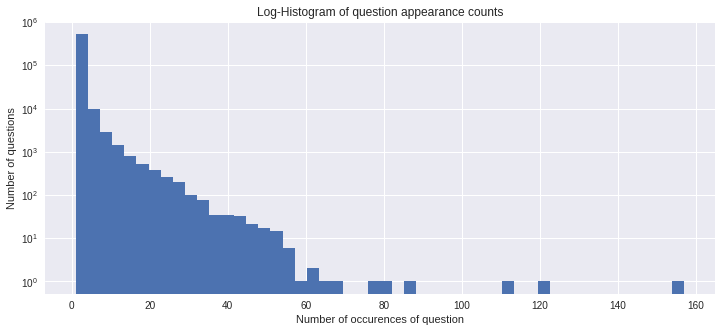

In [7]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

mean-train 59.86 std-train 31.99 mean-test 60.11 std-test 31.66 max-train 1169.00 max-test 1176.00


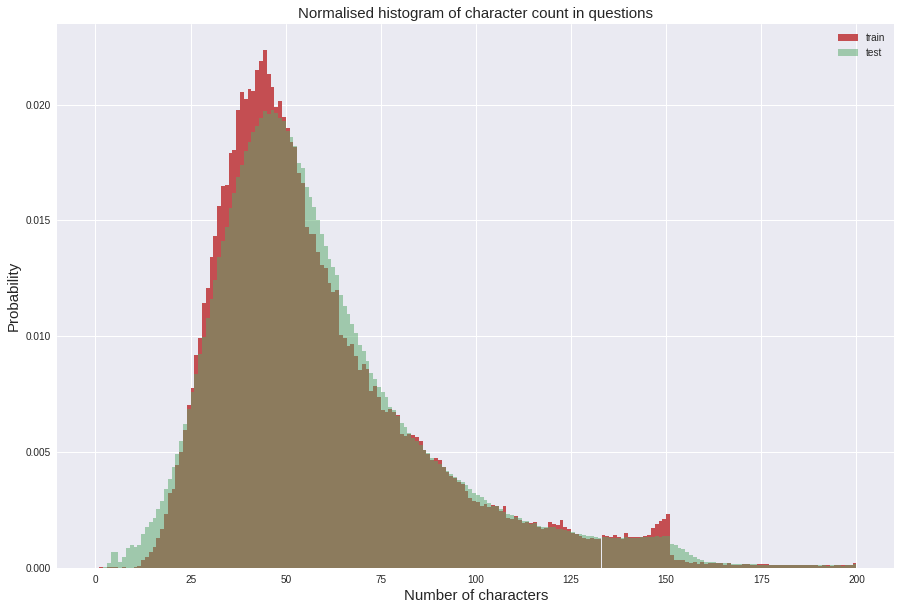

In [10]:
df_test = pd.read_csv('test.csv')
df_test.head()
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

11.0648556729 5.88916765019 11.0243088061 5.83992478925 237 238


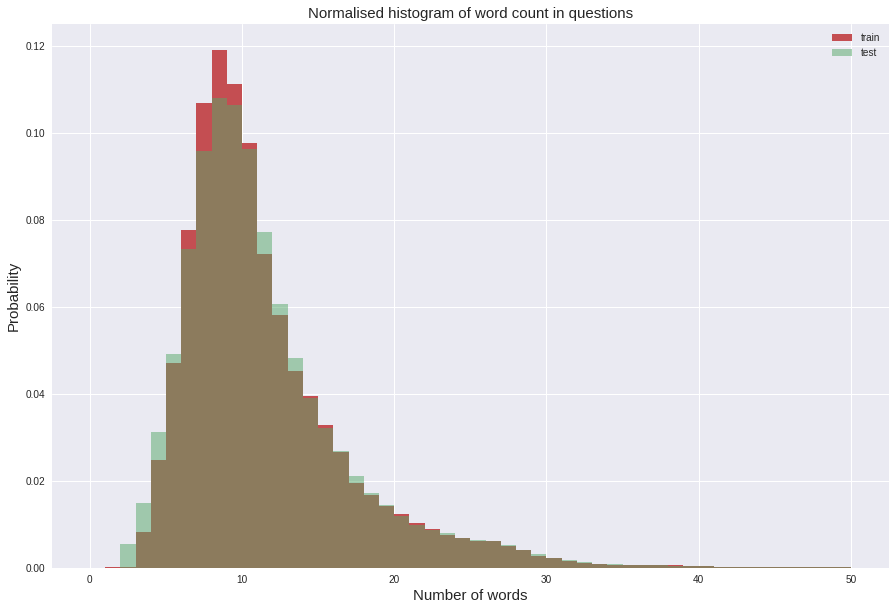

In [12]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print(dist_train.mean(),dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max())

(-0.5, 1439.5, 1079.5, -0.5)

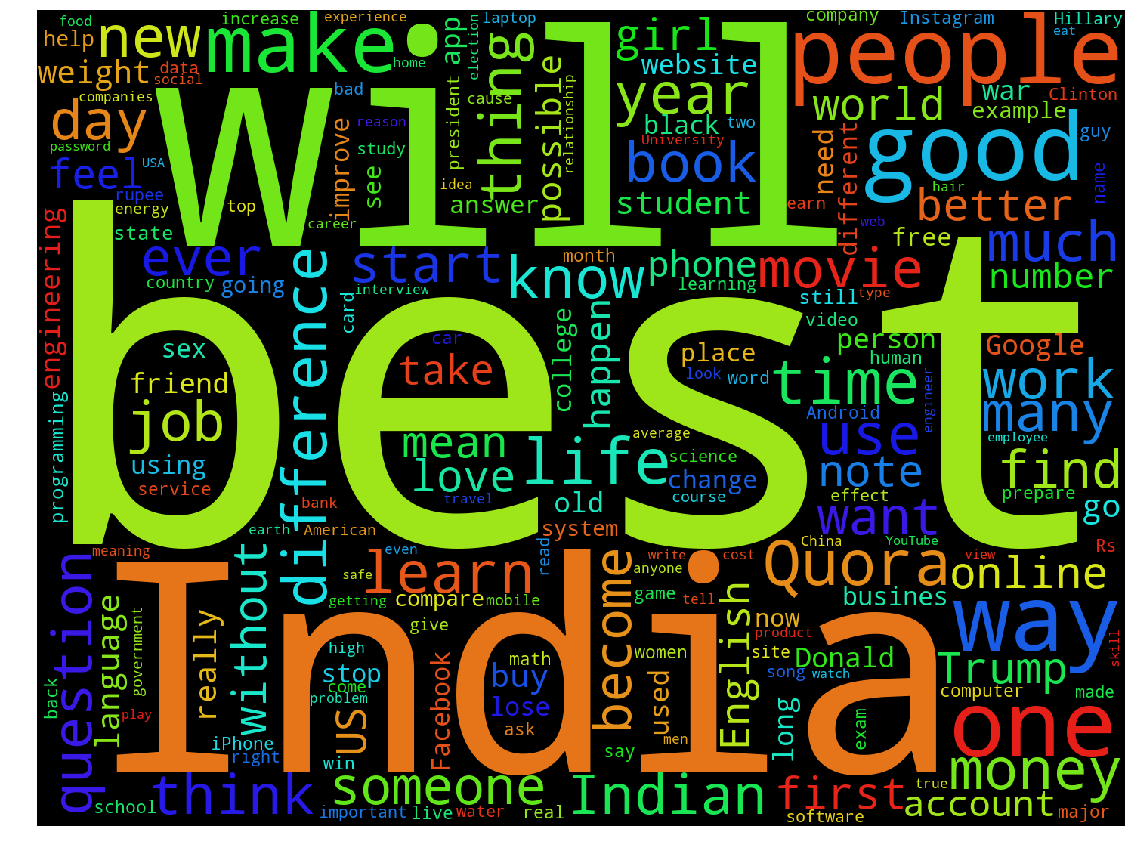

In [14]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

Let us now construct a few features
* character length of questions 1 and 2
* number of words in question 1 and 2
* normalized word share count.
We can then have a look at how well each of these separate the two classes.

In [15]:
# free up the space
del cloud
del df_test
del df_train

In [16]:
df = pd.read_csv("train.csv").fillna("")
df.head() 

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [17]:
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()

df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))


df['word_share'] = df.apply(normalized_word_share, axis=1)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,0.100000


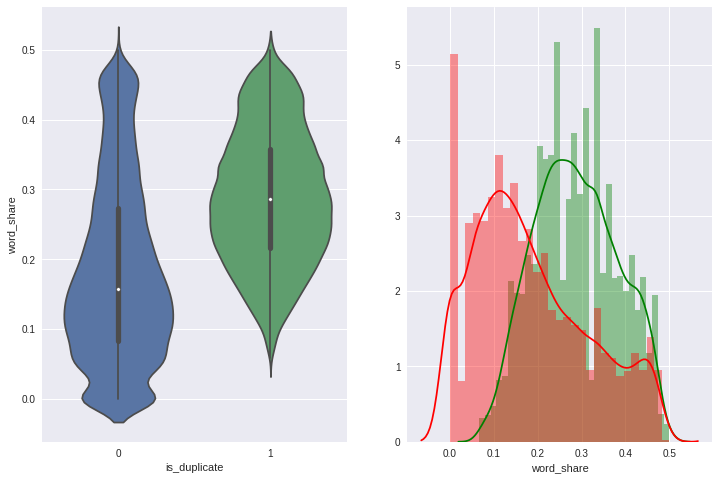

In [18]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:50000])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:10000], color = 'green')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:10000], color = 'red')

Scatter plot of question pair character lengths where color indicates duplicates and the size the word share coefficient we've calculated earlier.

In [21]:
df_subsampled = df[0:2000]

trace = go.Scatter(
    y = df_subsampled['q2len'].values,
    x = df_subsampled['q1len'].values,
    mode='markers',
    marker=dict(
        size= df_subsampled['word_share'].values * 60,
        color = df_subsampled['is_duplicate'].values,
        colorscale='Portland',
        showscale=True,
        opacity=0.5,
        colorbar = dict(title = 'duplicate')
    ),
    text = np.round(df_subsampled['word_share'].values, decimals=2)
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Scatter plot of character lengths of question one and two',
    hovermode= 'closest',
        xaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    yaxis=dict(
        title= 'Question 2 length',
        ticklen= 5,
        gridwidth= 2,
        showgrid=False,
        zeroline=False,
        showline=False,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatterWords')

In [25]:
from sklearn.preprocessing import MinMaxScaler

df_subsampled = df[0:3000]
X = MinMaxScaler().fit_transform(df_subsampled[['q1_n_words', 'q1len', 'q2_n_words', 'q2len', 'word_share']])
y = df_subsampled['is_duplicate'].values

Let us now construct a few features
* character length of questions 1 and 2
* number of words in question 1 and 2
* normalized word share count.
We can then have a look at how well each of these separate the two classes.

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=200,
    verbose=2,
    angle=0.5
).fit_transform(X)

In [29]:
trace1 = go.Scatter3d(
    x=tsne[:,0],
    y=tsne[:,1],
    z=tsne[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

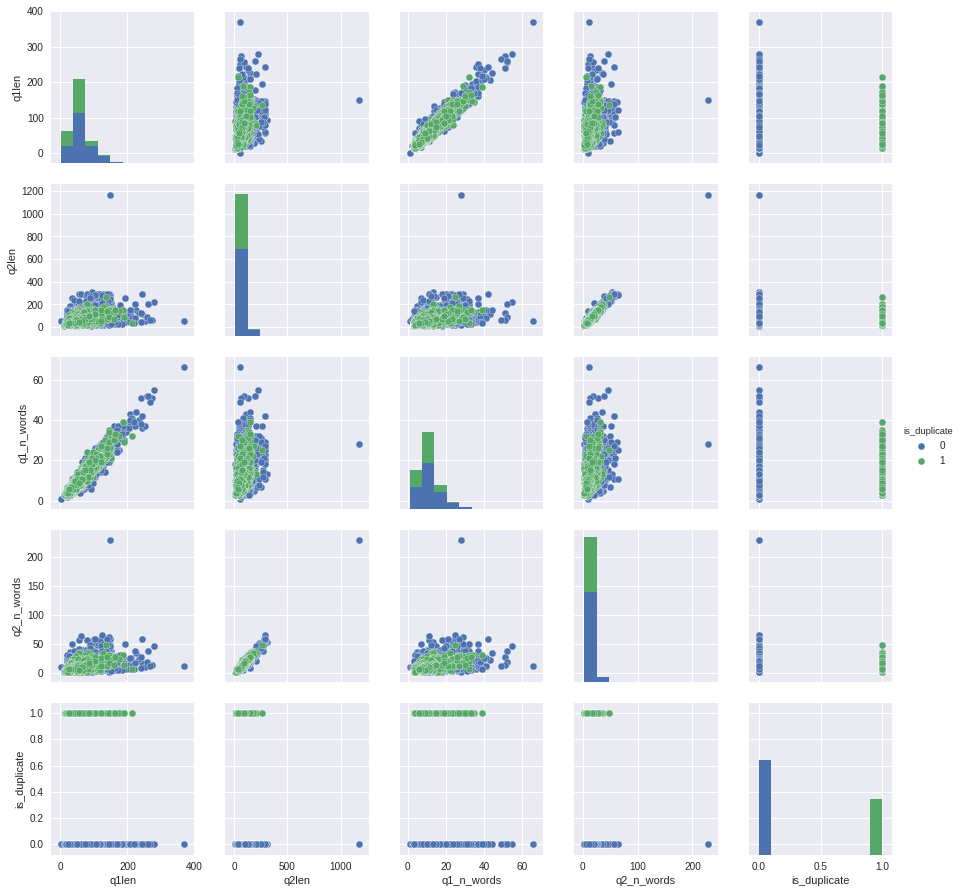

In [30]:
n = 10000
sns.pairplot(df[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'is_duplicate']][0:n], hue='is_duplicate')

# FINAL SOLUTION

In [1]:
import pandas as pd
from nltk.corpus import stopwords
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix,hstack
from sklearn.feature_extraction import text
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from scipy import sparse as ssp
from sklearn.datasets import dump_svmlight_file,load_svmlight_file
from sklearn.utils import resample,shuffle
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
import distance
import nltk
#nltk.download('stopwords')

stop_words = stopwords.words('english')
    
#stops = set(stopwords.words("english"))
stops = set(["http","www","img","border","home","body","a","about","above","after","again","against","all","am","an",
"and","any","are","aren't","as","at","be","because","been","before","being","below","between","both","but","by","can't",
"cannot","could","couldn't","did","didn't","do","does","doesn't","doing","don't","down","during","each","few","for","from",
"further","had","hadn't","has","hasn't","have","haven't","having","he","he'd","he'll","he's","her","here","here's","hers",
"herself","him","himself","his","how","how's","i","i'd","i'll","i'm","i've","if","in","into","is","isn't","it","it's","its",
"itself","let's","me","more","most","mustn't","my","myself","no","nor","not","of","off","on","once","only","or","other","ought",
"our","ours","ourselves","out","over","own","same","shan't","she","she'd","she'll","she's","should","shouldn't","so","some","such",
"than","that","that's","the","their","theirs","them","themselves","then","there","there's","these","they","they'd","they'll","they're",
"they've","this","those","through","to","too","under","until","up","very","was","wasn't","we","we'd","we'll","we're","we've","were",
"weren't","what","what's","when","when's""where","where's","which","while","who","who's","whom","why","why's","with","won't","would",
"wouldn't","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves" ])
porter = PorterStemmer() #это процесс нахождения основы слова для заданного исходного слова. 
#Основа слова необязательно совпадает с морфологическим корнем слова.
snowball = SnowballStemmer('english')

weights={}



In [2]:
def fromsparsetofile(filename, array, deli1=" ", deli2=":",ytarget=None):    
    zsparse=csr_matrix(array)
    indptr = zsparse.indptr
    indices = zsparse.indices
    data = zsparse.data
    print(" data lenth %d" % (len(data)))
    print(" indices lenth %d" % (len(indices)))    
    print(" indptr lenth %d" % (len(indptr)))
    
    f=open(filename,"w")
    counter_row=0
    for b in range(0,len(indptr)-1):
        #if there is a target, print it else , print nothing
        if ytarget!=None:
             f.write(str(ytarget[b]) + deli1)     
             
        for k in range(indptr[b],indptr[b+1]):
            if (k==indptr[b]):
                if np.isnan(data[k]):
                    f.write("%d%s%f" % (indices[k],deli2,-1))
                else :
                    f.write("%d%s%f" % (indices[k],deli2,data[k]))                    
            else :
                if np.isnan(data[k]):
                     f.write("%s%d%s%f" % (deli1,indices[k],deli2,-1))  
                else :
                    f.write("%s%d%s%f" % (deli1,indices[k],deli2,data[k]))
        f.write("\n")
        counter_row+=1
        if counter_row%10000==0:    
            print(" row : %d " % (counter_row))    
    f.close()  


In [3]:
# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=5000.0, min_count=2.0):
    if count < min_count:
        return 0.0
    else:
        return 1.0 / (count + eps)


def word_shares(row,wei,stop):
    
 
		q1 = set(str(row['question1']).lower().split())
		q1words = q1.difference(stop)
		if len(q1words) == 0:
			return '0:0:0:0:0'

		q2 = set(str(row['question2']).lower().split())
		q2words = q2.difference(stop)
		if len(q2words) == 0:
			return '0:0:0:0:0'

		q1stops = q1.intersection(stop)
		q2stops = q2.intersection(stop)

		shared_words = q1words.intersection(q2words)
		#print(len(shared_words))
		shared_weights = [wei.get(w, 0) for w in shared_words]
		total_weights = [wei.get(w, 0) for w in q1words] + [wei.get(w, 0) for w in q2words]
        
		R1 = np.sum(shared_weights) / np.sum(total_weights) #tfidf share
		R2 = float(len(shared_words)) / (float(len(q1words)) + float(len(q2words))) #count share
		R31 = float(len(q1stops)) / float(len(q1words)) #stops in q1
		R32 = float(len(q2stops)) / float(len(q2words)) #stops in q2
		return '{}:{}:{}:{}:{}'.format(R1, R2, float(len(shared_words)), R31, R32)

def stem_str(x,stemmer=SnowballStemmer('english')):
        x = text.re.sub("[^a-zA-Z0-9]"," ", x)
        x = (" ").join([stemmer.stem(z) for z in x.split(" ")])
        x = " ".join(x.split())
        return x
    
def calc_set_intersection(text_a, text_b):
    a = set(text_a.split())
    b = set(text_b.split())
    return len(a.intersection(b)) *1.0 / len(a)

def str_abs_diff_len(str1, str2):
    return abs(len(str1)-len(str2))

def str_len(str1):
    return len(str(str1))

def char_len(str1):
    str1_list = set(str(str1).replace(' ',''))
    return len(str1_list)

def word_len(str1):
    str1_list = str1.split(' ')
    return len(str1_list)

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stop_words:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stop_words:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))*1.0/(len(q1words) + len(q2words))
    return R

def str_jaccard(str1, str2):
    str1_list = str1.split(" ")
    str2_list = str2.split(" ")
    res = distance.jaccard(str1_list, str2_list)
    return res

# shortest alignment
def str_levenshtein_1(str1, str2):
    res = distance.nlevenshtein(str1, str2,method=1)
    return res

# longest alignment
def str_levenshtein_2(str1, str2):
    res = distance.nlevenshtein(str1, str2,method=2)
    return res

def str_sorensen(str1, str2):
    str1_list = str1.split(' ')
    str2_list = str2.split(' ')
    res = distance.sorensen(str1_list, str2_list)
    return res

In [4]:
def main():

    path="" 
    
    
     ################### generate_stem .py################## 
    seed = 1024
    np.random.seed(seed)
    path = '' 
    #re load to avoid errors. 
    
    train = pd.read_csv(path+"train.csv")
    test = pd.read_csv(path+"test.csv")

    print('Generate porter')
    
    train['question1_porter'] = train['question1'].astype(str).apply(lambda x:stem_str(x.lower(),porter))
    test['question1_porter'] = test['question1'].astype(str).apply(lambda x:stem_str(x.lower(),porter))
    
    train['question2_porter'] = train['question2'].astype(str).apply(lambda x:stem_str(x.lower(),porter))
    test['question2_porter'] = test['question2'].astype(str).apply(lambda x:stem_str(x.lower(),porter))
    
    train.to_csv(path+'train_porter.csv')
    test.to_csv(path+'test_porter.csv')
    

    ###################### generate_interaction.py ################    
    
    train = pd.read_csv(path+"train_porter.csv")
    test = pd.read_csv(path+"test_porter.csv")
    test['is_duplicated']=[-1]*test.shape[0]
    
    print('Generate intersection')
    train_interaction = train.astype(str).apply(lambda x:calc_set_intersection(x['question1'],x['question2']),axis=1)
    test_interaction = test.astype(str).apply(lambda x:calc_set_intersection(x['question1'],x['question2']),axis=1)
    pd.to_pickle(train_interaction,path+"train_interaction.pkl")
    pd.to_pickle(test_interaction,path+"test_interaction.pkl")
    
    print('Generate porter intersection')
    train_porter_interaction = train.astype(str).apply(lambda x:calc_set_intersection(x['question1_porter'],x['question2_porter']),axis=1)
    test_porter_interaction = test.astype(str).apply(lambda x:calc_set_intersection(x['question1_porter'],x['question2_porter']),axis=1)
    
    pd.to_pickle(train_porter_interaction,path+"train_porter_interaction.pkl")
    pd.to_pickle(test_porter_interaction,path+"test_porter_interaction.pkl")  
    
    ###################### generate_tfidf.py ################  

        
    ft = ['question1','question2','question1_porter','question2_porter']
    train = pd.read_csv(path+"train_porter.csv")[ft]
    test = pd.read_csv(path+"test_porter.csv")[ft]
    # test['is_duplicated']=[-1]*test.shape[0]
    
    data_all = pd.concat([train,test])
    print (data_all)
    
    max_features = None
    ngram_range = (1,2)
    min_df = 3
    print('Generate tfidf')
    feats= ['question1','question2']
    vect_orig = TfidfVectorizer(max_features=max_features,ngram_range=ngram_range, min_df=min_df)
    
    corpus = []
    for f in feats:
        data_all[f] = data_all[f].astype(str)
        corpus+=data_all[f].values.tolist()
    
    vect_orig.fit(corpus)
    
    for f in feats:
        tfidfs = vect_orig.transform(data_all[f].values.tolist())
        train_tfidf = tfidfs[:train.shape[0]]
        test_tfidf = tfidfs[train.shape[0]:]
        pd.to_pickle(train_tfidf,path+'train_%s_tfidf.pkl'%f)
        pd.to_pickle(test_tfidf,path+'test_%s_tfidf.pkl'%f)
    
    
    print('Generate porter tfidf')
    feats= ['question1_porter','question2_porter']
    vect_orig = TfidfVectorizer(max_features=max_features,ngram_range=ngram_range, min_df=min_df)
    
    corpus = []
    for f in feats:
        data_all[f] = data_all[f].astype(str)
        corpus+=data_all[f].values.tolist()
    
    vect_orig.fit(
        corpus
        )
    
    for f in feats:
        tfidfs = vect_orig.transform(data_all[f].values.tolist())
        train_tfidf = tfidfs[:train.shape[0]]
        test_tfidf = tfidfs[train.shape[0]:]
        pd.to_pickle(train_tfidf,path+'train_%s_tfidf.pkl'%f)
        pd.to_pickle(test_tfidf,path+'test_%s_tfidf.pkl'%f)    
        
        
    ##################### generate_len.py #########################
    
    train = pd.read_csv(path+"train_porter.csv").astype(str)
    test = pd.read_csv(path+"test_porter.csv").astype(str)
    
    print('Generate len')
    feats = []
    
    train['abs_diff_len'] = train.apply(lambda x:str_abs_diff_len(x['question1'],x['question2']),axis=1)
    test['abs_diff_len']= test.apply(lambda x:str_abs_diff_len(x['question1'],x['question2']),axis=1)
    feats.append('abs_diff_len')
    
    train['R']=train.apply(word_match_share, axis=1, raw=True)
    test['R']=test.apply(word_match_share, axis=1, raw=True)
    feats.append('R')
    
    train['common_words'] = train.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)
    test['common_words'] = test.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)
    feats.append('common_words')
    
    for c in ['question1','question2']:
        train['%s_char_len'%c] = train[c].apply(lambda x:char_len(x))
        test['%s_char_len'%c] = test[c].apply(lambda x:char_len(x))
        feats.append('%s_char_len'%c)
    
        train['%s_str_len'%c] = train[c].apply(lambda x:str_len(x))
        test['%s_str_len'%c] = test[c].apply(lambda x:str_len(x))
        feats.append('%s_str_len'%c)
        
        train['%s_word_len'%c] = train[c].apply(lambda x:word_len(x))
        test['%s_word_len'%c] = test[c].apply(lambda x:word_len(x))
        feats.append('%s_word_len'%c)
    

    pd.to_pickle(train[feats].values,path+"train_len.pkl")
    pd.to_pickle(test[feats].values,path+"test_len.pkl")       
    
    #########################generate_distance.py #################

    train = pd.read_csv(path+"train_porter.csv")
    test = pd.read_csv(path+"test_porter.csv")
    test['is_duplicated']=[-1]*test.shape[0]
    
    data_all = pd.concat([train,test])    
    
    print('Generate jaccard')
    train_jaccard = train.astype(str).apply(lambda x:str_jaccard(x['question1'],x['question2']),axis=1)
    test_jaccard = test.astype(str).apply(lambda x:str_jaccard(x['question1'],x['question2']),axis=1)
    pd.to_pickle(train_jaccard,path+"train_jaccard.pkl")
    pd.to_pickle(test_jaccard,path+"test_jaccard.pkl")
    
    print('Generate porter jaccard')
    train_porter_jaccard = train.astype(str).apply(lambda x:str_jaccard(x['question1_porter'],x['question2_porter']),axis=1)
    test_porter_jaccard = test.astype(str).apply(lambda x:str_jaccard(x['question1_porter'],x['question2_porter']),axis=1)
    
    pd.to_pickle(train_porter_jaccard,path+"train_porter_jaccard.pkl")
    pd.to_pickle(test_porter_jaccard,path+"test_porter_jaccard.pkl")  

    path=""
    ###################  generate_svm_format_tfidf.py ################# 
    train = pd.read_csv(path+"train_porter.csv")    
    
    train_question1_tfidf = pd.read_pickle(path+'train_question1_tfidf.pkl')[:]
    test_question1_tfidf = pd.read_pickle(path+'test_question1_tfidf.pkl')[:]

    
    train_question2_tfidf = pd.read_pickle(path+'train_question2_tfidf.pkl')[:]
    test_question2_tfidf = pd.read_pickle(path+'test_question2_tfidf.pkl')[:]
 

    #train_question1_porter_tfidf = pd.read_pickle(path+'train_question1_porter_tfidf.pkl')[:]
    #test_question1_porter_tfidf = pd.read_pickle(path+'test_question1_porter_tfidf.pkl')[:]
    
    #train_question2_porter_tfidf = pd.read_pickle(path+'train_question2_porter_tfidf.pkl')[:]
    #test_question2_porter_tfidf = pd.read_pickle(path+'test_question2_porter_tfidf.pkl')[:]
    
    
    train_interaction = pd.read_pickle(path+'train_interaction.pkl')[:].reshape(-1,1)
    test_interaction = pd.read_pickle(path+'test_interaction.pkl')[:].reshape(-1,1)

    train_interaction=np.nan_to_num(train_interaction)
    test_interaction=np.nan_to_num(test_interaction)      

    
    train_porter_interaction = pd.read_pickle(path+'train_porter_interaction.pkl')[:].reshape(-1,1)
    test_porter_interaction = pd.read_pickle(path+'test_porter_interaction.pkl')[:].reshape(-1,1)


    train_porter_interaction=np.nan_to_num(train_porter_interaction)
    test_porter_interaction=np.nan_to_num(test_porter_interaction)
    
    
    train_jaccard = pd.read_pickle(path+'train_jaccard.pkl')[:].reshape(-1,1)
    test_jaccard = pd.read_pickle(path+'test_jaccard.pkl')[:].reshape(-1,1)


    train_jaccard=np.nan_to_num(train_jaccard)
    test_jaccard=np.nan_to_num(test_jaccard)
    
    train_porter_jaccard = pd.read_pickle(path+'train_porter_jaccard.pkl')[:].reshape(-1,1)
    test_porter_jaccard = pd.read_pickle(path+'test_porter_jaccard.pkl')[:].reshape(-1,1)


    train_jaccard=np.nan_to_num(train_jaccard)
    test_porter_jaccard=np.nan_to_num(test_porter_jaccard)
    
    train_len = pd.read_pickle(path+"train_len.pkl")
    test_len = pd.read_pickle(path+"test_len.pkl")
    
    train_len=np.nan_to_num(train_len)
    test_len=np.nan_to_num(test_len) 
    

    scaler = MinMaxScaler()
    scaler.fit(np.vstack([train_len,test_len]))
    train_len = scaler.transform(train_len)
    test_len =scaler.transform(test_len)
 
    
    
    X = ssp.hstack([
        train_question1_tfidf,
        train_question2_tfidf,
        train_interaction,
        train_porter_interaction,
        train_jaccard,
        train_porter_jaccard,
        train_len
        ]).tocsr()
    
    
    y = train['is_duplicate'].values[:]
    
    X_t = ssp.hstack([
        test_question1_tfidf,
        test_question2_tfidf,
        test_interaction,
        test_porter_interaction,
        test_jaccard,
        test_porter_jaccard,
        test_len
        ]).tocsr()
    
    
    print (X.shape)
    print (X_t.shape)
    
    fromsparsetofile(path + "x_tfidf.svm", X, deli1=" ", deli2=":",ytarget=y)
    del X
    fromsparsetofile(path+"x_t_tfidf.svm", X_t, deli1=" ", deli2=":",ytarget=None)
    del X_t

    

    
    print ("done!") 

In [ ]:
main()

Generate porter
Generate intersection
Generate porter intersection
                                                 question1  \
0        What is the step by step guide to invest in sh...   
1        What is the story of Kohinoor (Koh-i-Noor) Dia...   
2        How can I increase the speed of my internet co...   
3        Why am I mentally very lonely? How can I solve...   
4        Which one dissolve in water quikly sugar, salt...   
5        Astrology: I am a Capricorn Sun Cap moon and c...   
6                                      Should I buy tiago?   
7                           How can I be a good geologist?   
8                          When do you use シ instead of し?   
9        Motorola (company): Can I hack my Charter Moto...   
10       Method to find separation of slits using fresn...   
11             How do I read and find my YouTube comments?   
12                    What can make Physics easy to learn?   
13             What was your first sexual experience like?   
14 

Generate porter tfidf
Generate len


/home/analyst/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:66: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
/home/analyst/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:69: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


Generate jaccard
Generate porter jaccard
